<a href="https://colab.research.google.com/github/FinnSkers/Cotton_Plant_Disease_checker/blob/main/CottonPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
path="/content/drive/MyDrive/archive/31-05-23"
IMAGESIZE=256
BATCHSIZE=20
EPOCHS=50
CHANNELS=3

In [ ]:

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(IMAGESIZE,IMAGESIZE),
    batch_size=BATCHSIZE
)

Found 240 files belonging to 6 classes.


In [ ]:
class_names=dataset.class_names
class_names
print(class_names)
print(len(class_names))

['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
6


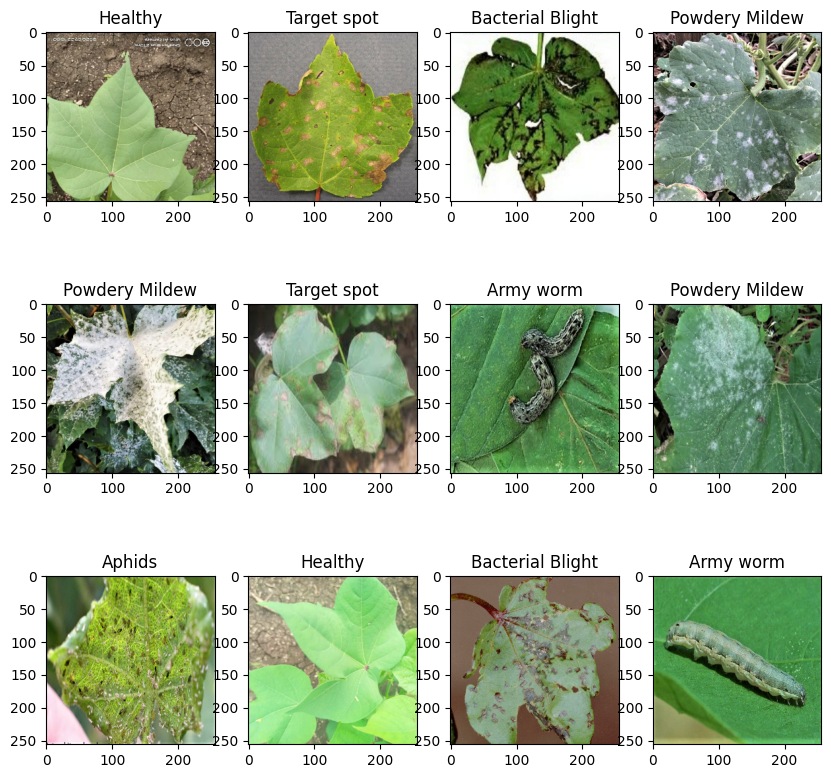

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])

In [ ]:
def get_dataset_part(ds, t_s=.8, v_s=.1, test_s=.1, shuffle=True, shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)
  t_size=int(ds_size*t_s)
  v_size=int(ds_size*v_s)
  train_ds=ds.take(t_size)
  val_ds=ds.skip(t_size).take(v_size)
  test_ds=ds.skip(t_size).skip(v_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_part(dataset)

In [ ]:
#len(train_ds)
len(val_ds)
#len(test_ds)

1

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGESIZE,IMAGESIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [ ]:
data_aug=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

In [ ]:
input_shape=(IMAGESIZE,IMAGESIZE,CHANNELS)
n_classes= len(class_names)
model=models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dense(6,activation='softmax')
])
model.build(input_shape=(20,256,256,3))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (20, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (20, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (20, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (20, 62, 62, 64)         0         
 g2D)                                                

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCHSIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
9/9 [==============================] - 7s 197ms/step - loss: 1.8019 - accuracy: 0.1278 - val_loss: 1.7735 - val_accuracy: 0.2500
Epoch 2/50
9/9 [==============================] - 0s 41ms/step - loss: 1.7608 - accuracy: 0.1833 - val_loss: 1.6566 - val_accuracy: 0.2500
Epoch 3/50
9/9 [==============================] - 0s 42ms/step - loss: 1.7487 - accuracy: 0.2222 - val_loss: 1.8236 - val_accuracy: 0.1000
Epoch 4/50
9/9 [==============================] - 0s 41ms/step - loss: 1.7927 - accuracy: 0.1889 - val_loss: 1.8067 - val_accuracy: 0.1000
Epoch 5/50
9/9 [==============================] - 0s 41ms/step - loss: 1.7889 - accuracy: 0.1833 - val_loss: 1.7954 - val_accuracy: 0.1000
Epoch 6/50
9/9 [==============================] - 0s 44ms/step - loss: 1.7671 - accuracy: 0.1611 - val_loss: 1.7726 - val_accuracy: 0.1500
Epoch 7/50
9/9 [==============================] - 0s 44ms/step - loss: 1.7392 - accuracy: 0.1889 - val_loss: 1.7781 - val_accuracy: 0.2500
Epoch 8/50
9/9 [==========

In [ ]:
scores=model.evaluate(test_ds)

2/2 [==============================] - 1s 24ms/step - loss: 0.6221 - accuracy: 0.7750


In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

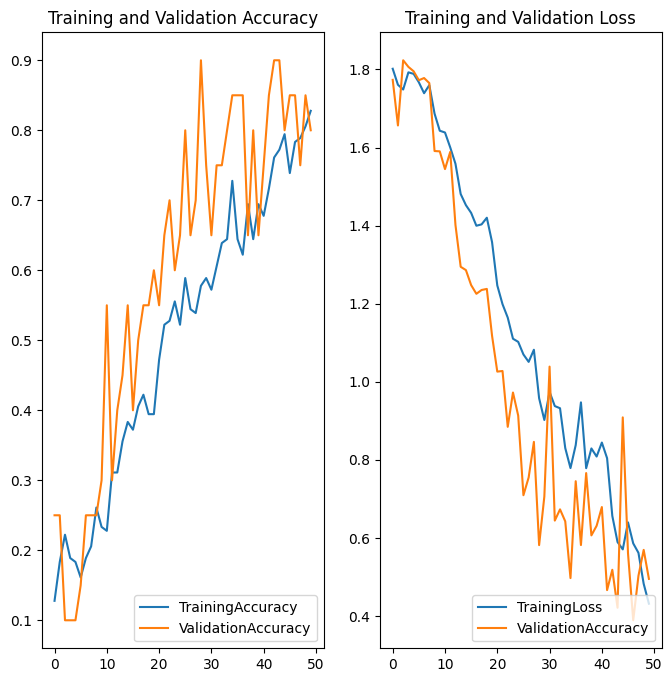

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='TrainingAccuracy')
plt.plot(range(EPOCHS),val_acc,label='ValidationAccuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='TrainingLoss')
plt.plot(range(EPOCHS),val_loss,label='ValidationAccuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
model.save('model.h5')

In [ ]:
model = load_model('model.h5')

img=image.load_img('test.jpg', target_size=(256,256))
img=image.img_to_array(img)
img= np.expand_dims(img, axis=0)

pred = model.predict(img)

print(class_names[np.argmax(pred)])